# Project 4-2-5: Boston Marathon Clustering

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline

from pandas.api.types import is_string_dtype

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.metrics import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_samples, silhouette_score


from sklearn import metrics

title_sz = 20
axis_sz = 16
tick_sz = 14

Every year 30,000 people run the Boston marathon. 20% of those runners are invited, and the other 80% qualify by having a qualifying time in another race where qualifying times are determined according to age bracket and gender.  

Acknowledging that runners come in seemingly every shape, size, age, gender, race, and probably every other trait category one could imagine, I am going to attempt to cluster the finishers of the 2014 Boston Marathon. 

# Cleaning the Data and dealing with missing values

In [2]:
df_all = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [3]:
cols = [col for col in df_all.columns]
print('DataFrame columns:', cols)
df_all.head()

DataFrame columns: ['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib', 'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k', 'half', '20k', 'country', 'city', '40k']


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
len(df_all)

31984

The dataset includes 31984 rows with information about gender, age, finishing time, pace, country of origin, place of residence, split times from the race, name, and a few administrative details about the racers. 

In [4]:
df_all = df_all.replace('-', np.nan)
# I found that almost all columns use '-' as an indicator of a missing value so I am 
# replacing them so they can be handled appropriately

In [5]:
for col in df_all.columns:
    try:
        df_all[col] =pd.to_numeric(df_all[col])
    except:
        print(col)

name
gender
bib
ctz
state
country
city


In [6]:
df_all.iloc[:, ~df_all.columns.isin([])].isna().sum()

10k             50
name             0
division         0
25k            216
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k             34
overall          0
pace             0
state         2576
30k             40
5k              52
half            72
20k             51
country          0
city             1
40k             39
dtype: int64

In [8]:
len(set(df_all[df_all['state'].isna()]['country']))

76

# Feature Engineering

I will drop name (which does not affect the final time), ctz (I believe citizenship, and which is absent for most entries), and city (which I believe will introduce an unhelpful level of detail), and convert gender to a binary. As far as state, rows without states indicate international athletes, so one option is to replace empty values of state with country, however including this information would introduce 126 variables to the set.  

At this time I'm still investigating how to handle 'division'.

In [7]:
df_all['country_state'] = [df_all['country'].iloc[ik] if type(state) != str else state  for ik, state in enumerate(df_all['state'])]

In [8]:
df = df_all.iloc[:, ~df_all.columns.isin(['name', 'bib', 'state', 'city', 'ctz', 'country'])]

In [9]:
df['gender'] = df['gender'].replace({'M':0, 'F':1})

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
df = df.dropna()

In [172]:
print('Dropping [name, bib, state, city, ctz] columns and then dropping rows with missing values still allowed us to retain ', 100*len(df)/len(df_all), '% of values')

Dropping [name, bib, state, city, ctz] columns and then dropping rows with missing values still allowed us to retain  98.95260130065033 % of values


In [11]:
# Always a useful couple of lines of code
categorical_cols = df.select_dtypes(exclude = [np.number])
numerical_cols = df.select_dtypes(include = [np.number])

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31649 entries, 0 to 31983
Data columns (total 16 columns):
10k              31649 non-null float64
division         31649 non-null int64
25k              31649 non-null float64
gender           31649 non-null int64
age              31649 non-null int64
official         31649 non-null float64
genderdiv        31649 non-null int64
35k              31649 non-null float64
overall          31649 non-null int64
pace             31649 non-null float64
30k              31649 non-null float64
5k               31649 non-null float64
half             31649 non-null float64
20k              31649 non-null float64
40k              31649 non-null float64
country_state    31649 non-null object
dtypes: float64(10), int64(5), object(1)
memory usage: 4.1+ MB


In [226]:
df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,country_state
0,17.37,8,47.67,0,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,JPN
1,32.58,1,82.43,1,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,KEN
2,16.62,1,45.80,0,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,RSA
3,32.57,3,82.43,1,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,ETH
4,17.12,2,46.37,0,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,JPN


In [14]:
categorical_cols.columns

Index(['country_state'], dtype='object')

In [12]:
# Found a nifty trick for transforming categorical variables to numerical variables
# for col, col_data in df.items():
#     if is_string_dtype(col_data):
#         df[col] = df[col].astype('category').cat.as_ordered().cat.codes

df = pd.concat([df, pd.get_dummies(df['country_state'],prefix='cs')], axis=1)

In [13]:
X = df.iloc[:, ~df.columns.isin(['division', 'genderdiv', 'country_state'])]

## Culling Features

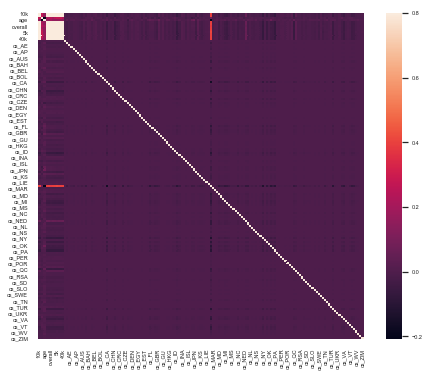

In [312]:
corrmat = X.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.5)
sns.heatmap(corrmat,annot=False, square=True, fmt='.2f', vmax=.8);

In [14]:
from sklearn.feature_selection import VarianceThreshold

qconstant_filter = VarianceThreshold(threshold=0.02)  
qconstant_filter.fit(X)  
print(len(X.columns[qconstant_filter.get_support()])  )
qconstant_columns = [col for col in X.columns  
                    if col not in X.columns[qconstant_filter.get_support()]]

len([col for col in qconstant_columns if 'cs_' in col]), X.shape

24


(133, (31649, 157))

In [15]:
useful_cols = X.columns[qconstant_filter.get_support()] 

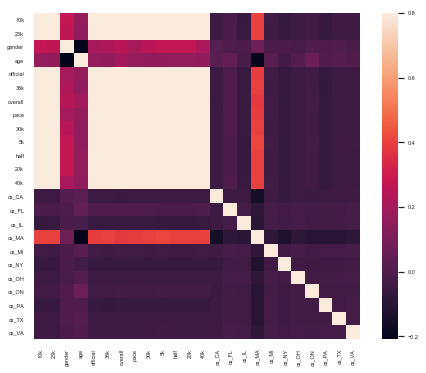

In [250]:
corrmat = X[useful_cols].corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.5)
sns.heatmap(corrmat,annot=False, square=True, fmt='.2f', vmax=.8);

# Clustering

In [25]:
def run_clusters(X, k):
    
    # MeanShift
    bandwidth = estimate_bandwidth(X, quantile=0.25, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Spectral
    sc = SpectralClustering(n_clusters=k, n_jobs = -1)
    
    # Affinity
    af = AffinityPropagation()
    
    # Agglomerative 
    ag = AgglomerativeClustering(linkage = 'ward', n_clusters = k)
    
    d_models = {'kmeans': kmeans, 
           'ag' : ag,
           'ms': ms
           } #'sc': sc,'af': af
    
    fig, ax = plt.subplots(ncols=len(d_models), nrows=1, figsize = (15,3))
    for ind, handle in enumerate(d_models.keys()):
        print(handle)
        model = d_models[handle]
        model.fit(X)
        try:
            y_pred = model.predict(X)
        except:
            y_pred = model.labels_
        ax[ind], score = make_sil_plot(X, y_pred, ax[ind], handle)
    
    return fig,ax,  score
    

In [17]:
def get_axis_limits(_ax, scale=.75):
    return _ax.get_xlim()[1]*scale, _ax.get_ylim()[1]*scale

def make_sil_plot(X, y_pred, _ax, handle)  :      
            score = metrics.silhouette_score(X, y_pred, metric='euclidean')
            
            N_CLUSTERS = len(set(y_pred))
            
            _ax.set_xlim([-0.1, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            _ax.set_ylim([0, len(X) + (N_CLUSTERS + 1) * 10])

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, y_pred)

            y_lower = 10
            for i in range(N_CLUSTERS):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[y_pred == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.spectral(float(i) / N_CLUSTERS)
                _ax.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)
                
                if N_CLUSTERS < 10:
                    # Label the silhouette plots with their cluster numbers at the middle
                    _ax.text(-0.07, y_lower + 0.45 * size_cluster_i, str(i), size=axis_sz)

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples
            
            _ax.annotate('avg.=\n'+ '%.2f' % score, xy=get_axis_limits(_ax), size=tick_sz)
            
            _ax.set_title(handle+', k ='+str(N_CLUSTERS), size=tick_sz )
            #_ax.set_xlabel("Silhouette Coefficient", fontsize=axis_sz)
            #_ax.set_ylabel("Cluster label",fontsize=axis_sz)

            # The vertical line for average silhoutte score of all the values
            _ax.axvline(x=score, color="red", linestyle="--", linewidth=3)

            _ax.set_yticks([])  # Clear the yaxis labels / ticks
            _ax.set_xticks([ 0, .3, .6, .9])

            xtickNames = _ax.get_xticklabels()
            ytickNames = _ax.get_yticklabels()

            plt.setp(ytickNames, rotation=0, fontsize=tick_sz)
            plt.setp(xtickNames, rotation=0, fontsize=tick_sz)
            
            return _ax, score

## Clustering with culled feature set

### Considering different values of k  

Try some quick analysis with kmeans and a range of k values

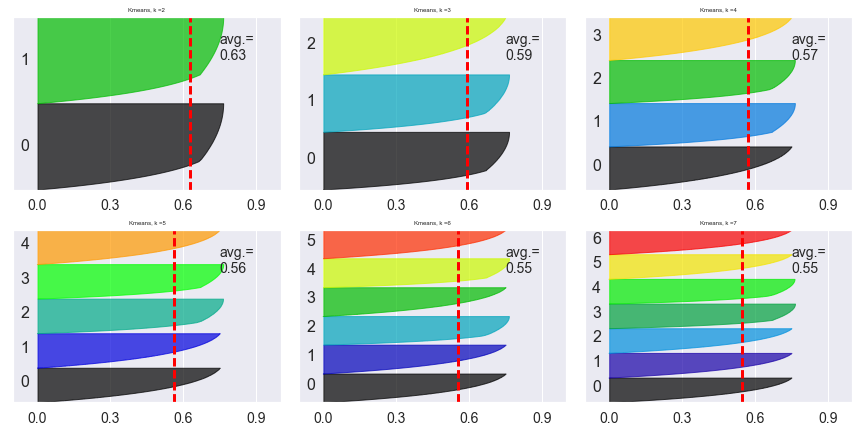

In [337]:
%config InlineBackend.figure_format = 'png'
scores = []
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for ik in range(0, 6, 1):
    ax = axes[int(ik / 3), ik%3]
    model = KMeans(n_clusters=ik+2, random_state=42)
    model.fit(X[useful_cols])
    try:
        y_pred = model.predict(X[useful_cols])
    except:
        y_pred = model.labels_
    ax, score = make_sil_plot(X[useful_cols], y_pred, ax, 'Kmeans')
    scores.append(score)

fig.tight_layout();
    

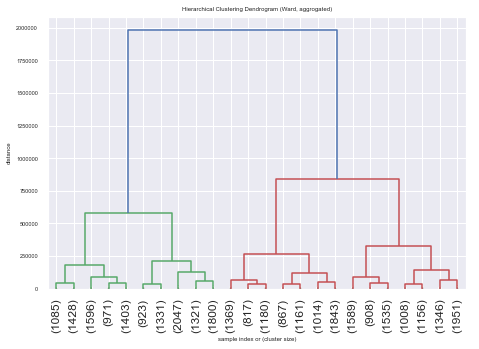

In [277]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(X, 'ward')

figure = plt.figure(figsize=(7.5, 5))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('Hierarchical Clustering Dendrogram (Ward, aggrogated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')

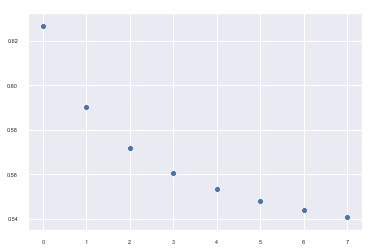

In [265]:
sns.scatterplot(x = [ik for ik in range(len(scores))], y = scores)

The above plot of silhouette score for kmeans clustering plotted against number of clusters complements the dendrogram, offering further support for a two cluster scheme.  

### Test a range of algorithms on the two feature sets

In [19]:
non_cs_cols = [col for col in X.columns if 'cs_' not in col]

In [20]:
X[non_cs_cols].describe()

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,half,20k,40k
count,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000
mean,51.629039,133.581175,0.447565,42.385067,241.952383,196.033373,15833.958924,9.236463,163.894883,25.678261,111.211481,105.321404,228.189990
std,8.710102,25.571480,0.497251,11.299795,50.842552,40.775036,9182.223743,1.939150,32.889354,4.215381,20.306387,19.159500,48.074493
min,16.620000,45.800000,0.000000,18.000000,80.600000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.370000,115.430000,0.000000,33.000000,205.300000,166.950000,7880.000000,7.830000,140.520000,22.620000,96.750000,91.670000,193.620000
50%,50.280000,128.850000,0.000000,42.000000,231.980000,187.850000,15829.000000,8.850000,157.500000,25.050000,107.680000,102.000000,218.470000
75%,57.000000,147.700000,1.000000,50.000000,272.200000,219.370000,23785.000000,10.380000,182.200000,28.400000,122.680000,116.150000,256.570000
max,112.380000,289.020000,1.000000,81.000000,538.880000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


kmeans
ag
ms


(<matplotlib.figure.Figure at 0x118b5cc50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1188b8588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1183b7da0>], dtype=object),
 0.5667416417708816)

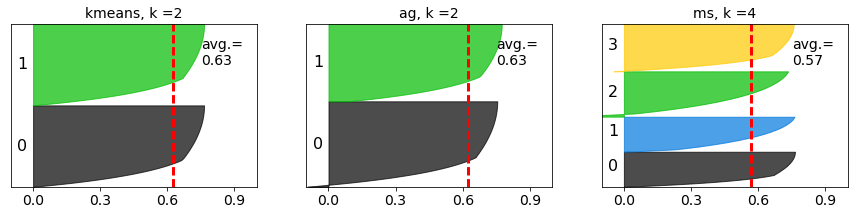

In [27]:
# Using the crafted feature set
run_clusters(X[useful_cols],2)

kmeans
ag
ms


(<matplotlib.figure.Figure at 0x115ae4c50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x117a2a630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11886fcf8>], dtype=object),
 0.56674174056580828)

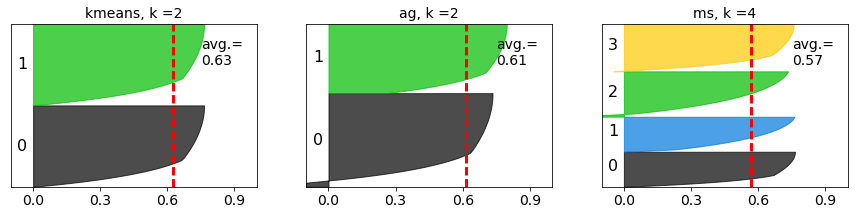

In [26]:
# Below I probed a bit to see if adding the country_state variable improved performance. 
# It seems that KMeans was invariant, but that it did contribute some information to Agglomerative Clustering.
run_clusters(X[non_cs_cols],2)

### Comparing best peforming models  

Comparing the two highest scoring algorithms across a few values of k, it seems that kmeans performs best.

(<matplotlib.figure.Figure at 0x1162a24a8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x109d992e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11071e400>], dtype=object),
 0.62513351034807707)

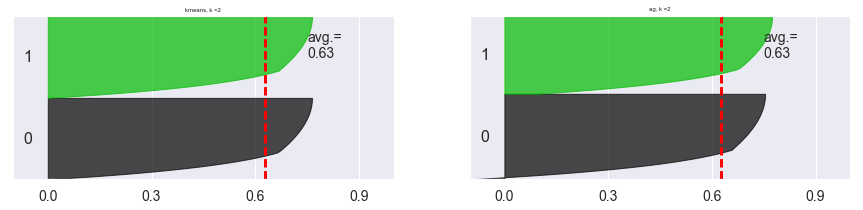

In [276]:
run_clusters(X[useful_cols],2)

(<matplotlib.figure.Figure at 0x10fe50f28>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1183e8278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118525a20>], dtype=object),
 0.55263024471000544)

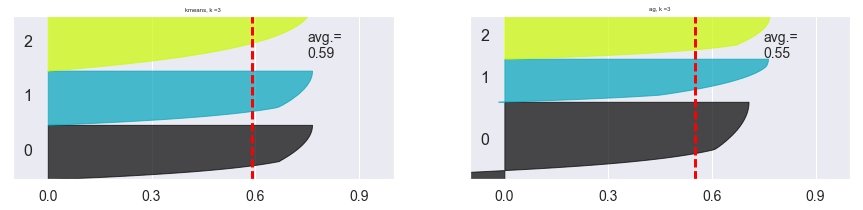

In [278]:
run_clusters(X[useful_cols],3)

(<matplotlib.figure.Figure at 0x119e37898>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x119e4dd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x109fdd0f0>], dtype=object),
 0.5710401458513501)

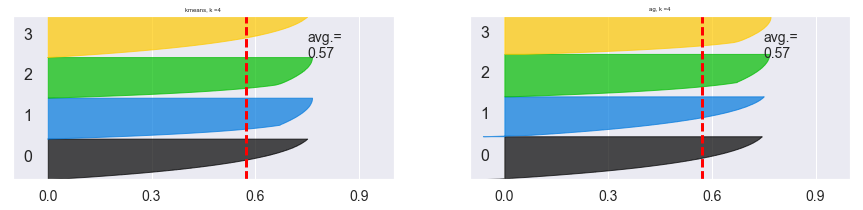

In [279]:
run_clusters(X[useful_cols],4)

# What can we say about the clusters?

In [313]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X[useful_cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [314]:
X['labels'] = kmeans.labels_

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [315]:
df_ones = X[X['labels']== 1]
df_zeros = X[X['labels']== 0]

In [316]:
df_ones[useful_cols].describe()

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,...,cs_FL,cs_IL,cs_MA,cs_MI,cs_NY,cs_OH,cs_ON,cs_PA,cs_TX,cs_VA
count,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,...,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.00000,15840.000000
mean,45.141688,114.328674,0.355051,40.324306,202.269818,164.667038,7890.029482,7.722904,138.906446,22.566323,...,0.025063,0.036616,0.091477,0.026073,0.060354,0.031061,0.037437,0.040783,0.03851,0.028093
std,4.395512,11.031857,0.478544,9.919625,20.084472,16.090189,4590.301833,0.766063,13.459739,2.225779,...,0.156322,0.187823,0.288296,0.159358,0.238148,0.173487,0.189836,0.197793,0.19243,0.165245
min,16.620000,45.800000,0.000000,18.000000,80.600000,67.420000,1.000000,3.080000,56.450000,7.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,42.270000,106.645000,0.000000,32.000000,188.900000,153.500000,3910.750000,7.220000,129.450000,21.150000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,45.480000,115.570000,0.000000,41.000000,205.320000,167.020000,7887.500000,7.830000,140.650000,22.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,48.370000,122.770000,1.000000,48.000000,218.220000,177.300000,11864.250000,8.330000,149.280000,24.130000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,60.700000,145.370000,1.000000,76.000000,232.050000,195.670000,15844.000000,8.870000,170.550000,36.570000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [309]:
df_zeros[useful_cols].describe()

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,...,cs_FL,cs_IL,cs_MA,cs_MI,cs_NY,cs_OH,cs_ON,cs_PA,cs_TX,cs_VA
count,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,...,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000,15812.000000
mean,58.128086,152.867348,0.540223,44.446876,281.703337,227.453692,23791.957248,10.752631,188.926649,28.795958,...,0.022009,0.020933,0.378131,0.017455,0.036744,0.016570,0.028586,0.022262,0.023906,0.016696
std,6.935513,21.062967,0.498395,12.187949,40.153041,33.100720,4593.628432,1.531324,27.046803,3.344253,...,0.146716,0.143166,0.484936,0.130964,0.188139,0.127656,0.166645,0.147538,0.152761,0.128135
min,36.870000,96.830000,0.000000,18.000000,232.030000,137.880000,15842.000000,8.850000,117.130000,17.900000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.230000,137.200000,0.000000,35.000000,248.865000,200.850000,19813.750000,9.500000,167.980000,26.470000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,57.000000,147.725000,1.000000,45.000000,272.260000,219.420000,23791.500000,10.400000,182.240000,28.380000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,62.380000,164.922500,1.000000,53.000000,306.400000,246.920000,27767.250000,11.700000,204.570000,30.885000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,112.380000,289.020000,1.000000,81.000000,538.880000,449.330000,31931.000000,20.570000,376.380000,86.950000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [303]:
sum(df_ones['gender']), sum(df_zeros['gender'])

(5623, 8542)

It appears that cluster 0 is slightly older than cluster 1 (44.44 $\pm$ 12.18 relative to 40.32 $\pm$ 9.9), includes more females (8542 females compared to 5623), and is slower (202 $\pm$ 20.08 versus 281.7 $\pm$ 40.15. 

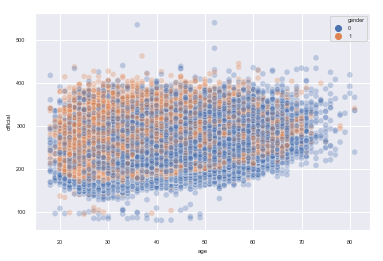

In [251]:
sns.scatterplot(x = X.sort_values(['age'])['age'], y = X.sort_values(['age'])['official'], hue = X.gender, alpha = .3)

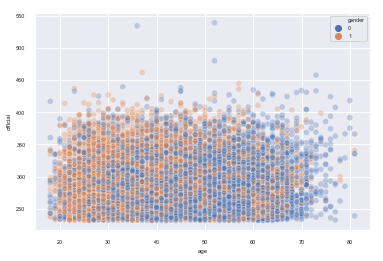

In [304]:
sns.scatterplot(x = df_zeros.sort_values(['age'])['age'], y = df_zeros.sort_values(['age'])['official'], hue = df_zeros.gender, alpha = .3)

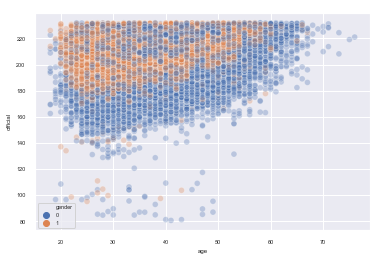

In [305]:
sns.scatterplot(x = df_ones.sort_values(['age'])['age'], y = df_ones.sort_values(['age'])['official'], hue = df_ones.gender, alpha = .3)

In [319]:
%config InlineBackend.figure_format = 'png'
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for ik, trait in enumerate(non_cs_cols):
    ax = axes[int(ik / 3), ik%3]
    sns.distplot(df_zeros[trait], ax = ax, color = 'b')
    sns.distplot(df_ones[trait], ax = ax, color = 'r')

fig.tight_layout();
    

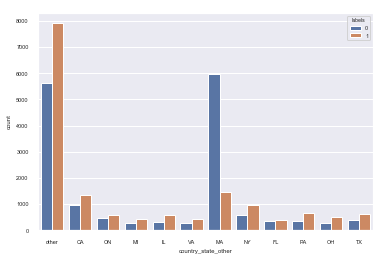

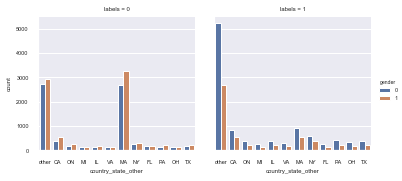

In [332]:
cs_cols = [col.strip('cs_') for col in useful_cols if 'cs_' in col]
X['country_state_other'] = [cs if cs in cs_cols else 'other' for cs in X.country_state]
ax = sns.countplot(x="country_state_other", hue = 'labels', data=X)

g = sns.catplot("country_state_other", col="labels", hue = 'gender',col_wrap=2,data=X,kind="count", height=2.5, aspect=1.02)

It appears that within cluster 0 the distribution of participants by gender is fairly consistent, with counts of women slightly higher than men in all categories.  However, within cluster 1, the counts of men were higher in every category listed. This pattern is consistent with what was observed in the prior scatter plots.  

# Test clustering within the clusters

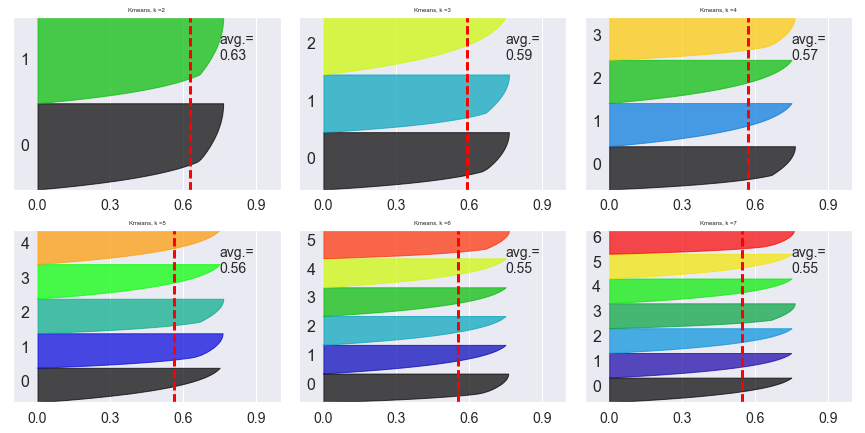

In [335]:
%config InlineBackend.figure_format = 'png'
scores = []
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for ik in range(0, 6, 1):
    ax = axes[int(ik / 3), ik%3]
    model = KMeans(n_clusters=ik+2, random_state=42)
    model.fit(df_zeros[useful_cols])
    try:
        y_pred = model.predict(df_zeros[useful_cols])
    except:
        y_pred = model.labels_
    ax, score = make_sil_plot(df_zeros[useful_cols], y_pred, ax, 'Kmeans')
    scores.append(score)

fig.tight_layout();

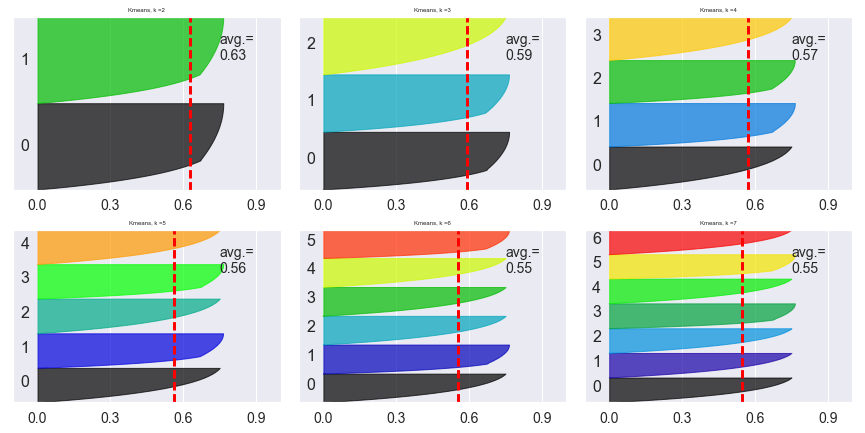

In [336]:
%config InlineBackend.figure_format = 'png'
scores = []
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for ik in range(0, 6, 1):
    ax = axes[int(ik / 3), ik%3]
    model = KMeans(n_clusters=ik+2, random_state=42)
    model.fit(df_ones[useful_cols])
    try:
        y_pred = model.predict(df_ones[useful_cols])
    except:
        y_pred = model.labels_
    ax, score = make_sil_plot(df_ones[useful_cols], y_pred, ax, 'Kmeans')
    scores.append(score)

fig.tight_layout();